# Plasmids MILP experiment: modified graph anf edge novelty

## Description

The following describes the experiment with iterative Plasmids assembly MILP with additional constraints to remove cycles. The plasmids obtained in this experiment have exactly one component as a path and possible more that are cycles. This has been achieved by adding two types of constraints:
1. The number of contigs in the plasmid should be exactly one more than the number of links in the plasmid.
2. However, the first constraint can also be satisfied by graphs with multiple component containing exactly 1 path and the rest as cycles. Hence, we add constraints to remove any cyclic sequence of contigs in the plasmid. The resulting plasmid will contain exactly one path. 
As the number of cycles generated can be exponential, we add the second type of constraints iteratively as we identify a cyclic sequence. So, for instance, for a plasmid $p$, let $\{a,b,c,d\}$ be contigs involved in a cycle and $\{a_hb_h,b_tc_t,c_hd_t,d_ha_t\}$ be the links in the cycle, we add exactly one constraint:

links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] $\leq$ 3

If the number of such constraints is greater than 50 (which seems to happen frequently), the linearization is performed greedily removing the least weighted link in each remaining cycle. 

3. In order to allow for multiple copies of the contig to occur in the same plasmid, we modify the assembly graph as follows:
- Each contig $c$ of the graph has a read depth $k$ associated with it. We split the contig into $k$ copies $c_1, c_2, ..., c_k$.
- Any link incident on $c$ in the original graph is incident on every $c_i$ in the modified graph.
- Each copy $c_i$ has read depth 1. The other attributes (gene density, GC content and length) remain the same as for the original contig $c$.

4. In order to avoid redundant edges and repetitive cycles, we add edge novelty constraints. For instance, if an edge $({a_1}_h,{b_2}_t)$ between has already been used (links[$p$][${a_1}_h,{b_2}_t$]==1), then any other edge $({a_i}_h,{b_j}_t)$ will not be part of the solution. 

In addition to these constraints, we also separate questionable plasmids away from putative plasmids. The conditions under which a plasmid is classified as putative are as follows:

1. min_gene_density[plasmid] $\geq$ 0.3
2. min_gene_density[seed_contig] $\geq$ 1.5$*$min_gene_density[plasmid] $=$ 0.45
3. 1500 $\leq$ min_length[plasmid] $\leq$ 1750000

In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Figure 1: Linearization to obtain single component

In [27]:
%load_ext autoreload
%autoreload 2
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

#import obtain_stats_v2
 #import the module here, so that it can be reloaded.
import importlib
from ipynb.fs.full.obtain_stats_v2 import * #import the module here, so that it can be reloaded.
#importlib.reload(ipynb.fs.full.obtain_stats_v2)
plt.switch_backend('agg')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


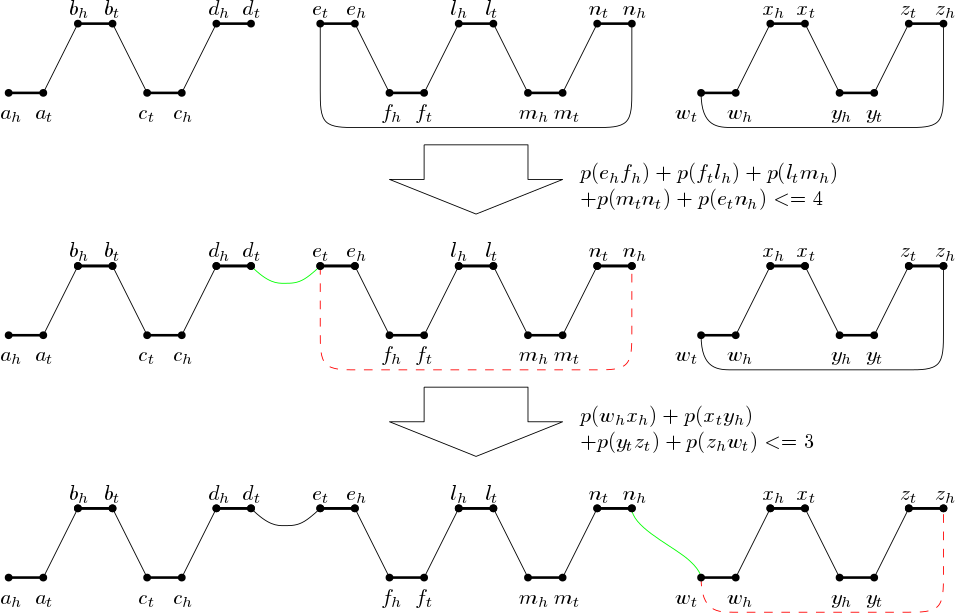

In [28]:
Image(filename="linearization.png", width=600)

In [29]:
greedy_dir = '../contigs'
ilp_dir = '../output'
output_dir = '../output'

## Statistics for different samples

In this part, we use the $\alpha$ ratios 1.1.1 as in the greedy heuristic. The MILP was run with nplasmids  $=1$. In other words, although we remove one plasmid at a time in this experiment, the MILP has provisions to remove $k>$1 plasmids in one iteration, provided convergence is reached. The main motivation behind the iterative plasmid generation approach is to help in reaching convergence by reducing the number of variables.

A set of 10 ids was chosen to test the general performance of the MILP. These were the same ids as the ones chosen to test the greedy algorithm.

The results for the 10 chosen sample ids have been compared with the results of the greedy heuristic, HyAsP. 

In [30]:
def read_file(filename):
	string = open(filename, "r").read()
	string_list = string.split("\n")
	string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
	return string_list

In [31]:
def get_contig_sets(plasmids, flag):
    contig_sets = {}
    for sample in plasmids:
        contig_sets[sample] = {}
        total = set()
        for plasmid in plasmids[sample]:
            chain = plasmids[sample][plasmid]
            if flag == 1:
                chain = [x.split("_")[0] for x in chain]
            else:
                chain = [x[:-1] for x in chain]
            contig_sets[sample][plasmid] = set(chain)
            total = total.union(contig_sets[sample][plasmid])
        contig_sets[sample]['Overall'] = total    
    return contig_sets

In [32]:
details_dict = {}
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if "details.csv" in f]
for file in files:
    if 'sample' in file.split('/')[2]:
        sample_id = file.split('/')[2].split('_')[1]
        details_dict[sample_id] = {}
        with open(file, 'r') as f:
            for line in f:
                if line[0].isdigit():
                    line = line.split("\t")
                    contig = line[0].split("_")[0]
                    gd = float(line[1])
                    rd = int(line[2])
                    gc = float(line[3])
                    length = int(line[4])
                    if contig not in details_dict[sample_id]:
                        details_dict[sample_id][contig] = {}
                        details_dict[sample_id][contig]['density'] = gd
                        details_dict[sample_id][contig]['read_depth'] = rd
                        details_dict[sample_id][contig]['GC_cont'] = gc
                        details_dict[sample_id][contig]['length'] = length
                    else:
                        details_dict[sample_id][contig]['read_depth'] += 1                

In [33]:
ILP_chains = {}
ILP_sets = {}
for sample in ['11','39','56','66','103','109','116','117','125']:
    ILP_chains[sample] = {} 
    chain_file = output_dir + '/sample_' + sample + '/1.1.1/nplasmids_1/MILP/contig_chains.csv'
    string_list = read_file(chain_file)
    
    for line in string_list:
        line = line.split(';')
        plasmid = line[0]
        chain = line[1].split(",")
        ILP_chains[sample][plasmid] = chain
ILP_sets = get_contig_sets(ILP_chains, 1) 

In [34]:
true_chains = {}
true_sets = {}
for sample in ['11','39','56','66','103','109','116','117','125']:
    true_chains[sample] = {} 
    chain_file = '../contigs/sample_' + sample + '/contig_chains.csv'
    string_list = read_file(chain_file)
    
    for line in string_list:
        line = line.split(';')
        plasmid = line[0]
        chain = line[1].split(",")
        true_chains[sample][plasmid] = chain
true_sets = get_contig_sets(true_chains, 0) 

In [35]:
greedy_chains = {}
greedy_sets = {}
for sample in ['11','39','56','66','103','109','116','117','125']:
    greedy_chains[sample] = {} 
    chain_file = '../contigs/sample_' + sample + '/greedy_contig_chains.csv'
    string_list = read_file(chain_file)
    
    for line in string_list:
        line = line.split(';')
        plasmid = line[0]
        chain = line[1].split(",")
        greedy_chains[sample][plasmid] = chain
greedy_sets = get_contig_sets(greedy_chains, 0) 

In [36]:
naive_eval = {}
for sample in ILP_sets:
    naive_eval[sample] = {}
    naive_eval[sample]['ILP_common'] = ILP_sets[sample]['Overall'].intersection(true_sets[sample]['Overall'])
    naive_eval[sample]['ILP_missing'] = true_sets[sample]['Overall'].difference(ILP_sets[sample]['Overall'])
    naive_eval[sample]['ILP_extra'] = ILP_sets[sample]['Overall'].difference(true_sets[sample]['Overall'])
    naive_eval[sample]['greedy_common'] = greedy_sets[sample]['Overall'].intersection(true_sets[sample]['Overall'])
    naive_eval[sample]['greedy_missing'] = true_sets[sample]['Overall'].difference(greedy_sets[sample]['Overall'])
    naive_eval[sample]['greedy_extra'] = greedy_sets[sample]['Overall'].difference(true_sets[sample]['Overall'])
    naive_eval[sample]['ILP_greedy'] = ILP_sets[sample]['Overall'].intersection(greedy_sets[sample]['Overall'])
    naive_eval[sample]['greedy_not_ILP'] = greedy_sets[sample]['Overall'].difference(ILP_sets[sample]['Overall'])
    naive_eval[sample]['ILP_not_greedy'] = ILP_sets[sample]['Overall'].difference(greedy_sets[sample]['Overall'])    

In [37]:
print('Sample\tContig\tDensity\tGC\tLength')
for sample in naive_eval:
    #print(sample)
    
    for contig in naive_eval[sample]['ILP_not_greedy']:
        #print(contig)
        if contig in details_dict[sample]:
            gd, gc, length = details_dict[sample][contig]['density'], details_dict[sample][contig]['GC_cont'], details_dict[sample][contig]['length']
            print(sample,'\t',contig,'\t',"{:.2f}".format(gd),'\t',"{:.2f}".format(gc),'\t',length)
    print("\n") 

Sample	Contig	Density	GC	Length
11 	 81 	 0.00 	 0.38 	 13
11 	 32 	 0.00 	 0.44 	 8748
11 	 62 	 0.00 	 0.57 	 141
11 	 52 	 0.00 	 0.51 	 366
11 	 43 	 0.00 	 0.53 	 1711
11 	 86 	 0.00 	 0.00 	 1
11 	 67 	 0.00 	 0.49 	 73
11 	 48 	 0.91 	 0.54 	 1203
11 	 34 	 0.88 	 0.53 	 7500
11 	 70 	 0.00 	 0.59 	 70
11 	 22 	 0.00 	 0.52 	 43320
11 	 30 	 0.90 	 0.62 	 9823
11 	 68 	 0.00 	 0.53 	 73
11 	 37 	 0.86 	 0.61 	 3206
11 	 45 	 0.82 	 0.50 	 1382
11 	 57 	 0.00 	 0.43 	 194
11 	 72 	 0.00 	 0.44 	 63
11 	 47 	 0.93 	 0.50 	 1229
11 	 19 	 0.00 	 0.46 	 47613
11 	 61 	 0.00 	 0.53 	 144
11 	 75 	 0.00 	 0.40 	 53
11 	 38 	 0.00 	 0.53 	 2930
11 	 78 	 0.00 	 0.55 	 20


39 	 63 	 1.00 	 0.56 	 1632
39 	 51 	 0.00 	 0.56 	 4026
39 	 65 	 1.00 	 0.53 	 1457
39 	 32 	 0.00 	 0.50 	 15030
39 	 125 	 0.00 	 0.60 	 35
39 	 52 	 0.00 	 0.52 	 3893
39 	 43 	 0.76 	 0.43 	 7716
39 	 49 	 0.81 	 0.51 	 4174
39 	 27 	 0.01 	 0.49 	 25721
39 	 48 	 0.36 	 0.48 	 5167
39 	 113 	 1.00 	 0.42 	 85

In [38]:
print('Sample\tContig\tDensity\tGC\tLength')
for sample in naive_eval:
    #print(sample)
    
    for contig in naive_eval[sample]['ILP_extra']:
        #print(contig)
        if contig in details_dict[sample]:
            gd, gc, length = details_dict[sample][contig]['density'], details_dict[sample][contig]['GC_cont'], details_dict[sample][contig]['length']
            print(sample,'\t',contig,'\t',"{:.2f}".format(gd),'\t',"{:.2f}".format(gc),'\t',length)
    print("\n") 

Sample	Contig	Density	GC	Length
11 	 81 	 0.00 	 0.38 	 13
11 	 65 	 0.00 	 0.49 	 79
11 	 32 	 0.00 	 0.44 	 8748
11 	 62 	 0.00 	 0.57 	 141
11 	 52 	 0.00 	 0.51 	 366
11 	 43 	 0.00 	 0.53 	 1711
11 	 27 	 0.00 	 0.53 	 18376
11 	 86 	 0.00 	 0.00 	 1
11 	 67 	 0.00 	 0.49 	 73
11 	 48 	 0.91 	 0.54 	 1203
11 	 34 	 0.88 	 0.53 	 7500
11 	 70 	 0.00 	 0.59 	 70
11 	 22 	 0.00 	 0.52 	 43320
11 	 79 	 0.00 	 0.47 	 15
11 	 69 	 0.00 	 0.61 	 70
11 	 59 	 0.99 	 0.54 	 157
11 	 31 	 0.93 	 0.58 	 8915
11 	 80 	 0.00 	 0.64 	 14
11 	 68 	 0.00 	 0.53 	 73
11 	 50 	 1.00 	 0.54 	 732
11 	 45 	 0.82 	 0.50 	 1382
11 	 55 	 1.00 	 0.52 	 258
11 	 57 	 0.00 	 0.43 	 194
11 	 72 	 0.00 	 0.44 	 63
11 	 47 	 0.93 	 0.50 	 1229
11 	 19 	 0.00 	 0.46 	 47613
11 	 44 	 0.81 	 0.44 	 1639
11 	 61 	 0.00 	 0.53 	 144
11 	 75 	 0.00 	 0.40 	 53
11 	 38 	 0.00 	 0.53 	 2930
11 	 36 	 0.82 	 0.47 	 3300
11 	 40 	 0.90 	 0.48 	 2274
11 	 78 	 0.00 	 0.55 	 20


39 	 63 	 1.00 	 0.56 	 1632
39 	 51 	

In [39]:
print('Sample\tContig\tDensity\tGC\tLength')
for sample in naive_eval:
    #print(sample)
    
    for contig in naive_eval[sample]['greedy_extra']:
        #print(contig)
        if contig in details_dict[sample]:
            gd, gc, length = details_dict[sample][contig]['density'], details_dict[sample][contig]['GC_cont'], details_dict[sample][contig]['length']
            print(sample,'\t',contig,'\t',"{:.2f}".format(gd),'\t',"{:.2f}".format(gc),'\t',length)
    print("\n") 

Sample	Contig	Density	GC	Length
11 	 50 	 1.00 	 0.54 	 732
11 	 79 	 0.00 	 0.47 	 15
11 	 69 	 0.00 	 0.61 	 70
11 	 33 	 0.00 	 0.45 	 7672
11 	 65 	 0.00 	 0.49 	 79
11 	 55 	 1.00 	 0.52 	 258
11 	 59 	 0.99 	 0.54 	 157
11 	 36 	 0.82 	 0.47 	 3300
11 	 27 	 0.00 	 0.53 	 18376
11 	 31 	 0.93 	 0.58 	 8915
11 	 80 	 0.00 	 0.64 	 14
11 	 40 	 0.90 	 0.48 	 2274
11 	 44 	 0.81 	 0.44 	 1639


39 	 29 	 0.00 	 0.51 	 19717
39 	 108 	 0.00 	 0.58 	 113
39 	 55 	 0.89 	 0.47 	 2582
39 	 106 	 0.67 	 0.44 	 123
39 	 102 	 1.00 	 0.50 	 127
39 	 42 	 0.00 	 0.39 	 10045
39 	 73 	 0.56 	 0.49 	 539


56 	 216 	 0.00 	 0.43 	 7
56 	 211 	 0.00 	 0.69 	 13
56 	 62 	 0.84 	 0.46 	 3321
56 	 202 	 0.00 	 0.52 	 23
56 	 205 	 0.00 	 0.44 	 16
56 	 87 	 0.86 	 0.54 	 1296
56 	 129 	 0.18 	 0.43 	 341
56 	 168 	 0.00 	 0.48 	 114
56 	 71 	 0.82 	 0.61 	 1966


66 	 103 	 0.00 	 0.54 	 24


103 	 24 	 0.00 	 0.52 	 44815
103 	 13 	 0.01 	 0.51 	 171608
103 	 34 	 0.00 	 0.64 	 2408


109 	 84 	

In [40]:
print('Sample\tContig\tDensity\tGC\tLength')
for sample in naive_eval:
    for contig in naive_eval[sample]['ILP_extra']:
        gd, gc, length = details_dict[sample][contig]['density'], details_dict[sample][contig]['GC_cont'], details_dict[sample][contig]['length']
        print(sample,'\t',contig,'\t',"{:.2f}".format(gd),'\t',"{:.2f}".format(gc),'\t',length)
    print("\n")    

Sample	Contig	Density	GC	Length
11 	 81 	 0.00 	 0.38 	 13
11 	 65 	 0.00 	 0.49 	 79
11 	 32 	 0.00 	 0.44 	 8748
11 	 62 	 0.00 	 0.57 	 141
11 	 52 	 0.00 	 0.51 	 366
11 	 43 	 0.00 	 0.53 	 1711
11 	 27 	 0.00 	 0.53 	 18376
11 	 86 	 0.00 	 0.00 	 1
11 	 67 	 0.00 	 0.49 	 73
11 	 48 	 0.91 	 0.54 	 1203
11 	 34 	 0.88 	 0.53 	 7500
11 	 70 	 0.00 	 0.59 	 70
11 	 22 	 0.00 	 0.52 	 43320
11 	 79 	 0.00 	 0.47 	 15
11 	 69 	 0.00 	 0.61 	 70
11 	 59 	 0.99 	 0.54 	 157
11 	 31 	 0.93 	 0.58 	 8915
11 	 80 	 0.00 	 0.64 	 14
11 	 68 	 0.00 	 0.53 	 73
11 	 50 	 1.00 	 0.54 	 732
11 	 45 	 0.82 	 0.50 	 1382
11 	 55 	 1.00 	 0.52 	 258
11 	 57 	 0.00 	 0.43 	 194
11 	 72 	 0.00 	 0.44 	 63
11 	 47 	 0.93 	 0.50 	 1229
11 	 19 	 0.00 	 0.46 	 47613
11 	 44 	 0.81 	 0.44 	 1639
11 	 61 	 0.00 	 0.53 	 144
11 	 75 	 0.00 	 0.40 	 53
11 	 38 	 0.00 	 0.53 	 2930
11 	 36 	 0.82 	 0.47 	 3300
11 	 40 	 0.90 	 0.48 	 2274
11 	 78 	 0.00 	 0.55 	 20


39 	 63 	 1.00 	 0.56 	 1632
39 	 51 	

In [41]:
def get_tlen(sample, details_dict, contigs):
    tlen = 0
    if len(contigs) != 0:
        for c in contigs:
            tlen += details_dict[sample][c]['length']
    return tlen        

In [42]:
naive_lengths = {} 
for sample in naive_eval:
    naive_lengths[sample] = {}
    naive_lengths[sample]['ILP_common'] = get_tlen(sample, details_dict, naive_eval[sample]['ILP_common'])
    naive_lengths[sample]['ILP_missing'] = get_tlen(sample, details_dict, naive_eval[sample]['ILP_missing'])
    naive_lengths[sample]['ILP_extra'] = get_tlen(sample, details_dict, naive_eval[sample]['ILP_extra'])
    naive_lengths[sample]['greedy_common'] = get_tlen(sample, details_dict, naive_eval[sample]['greedy_common'])
    naive_lengths[sample]['greedy_missing'] = get_tlen(sample, details_dict, naive_eval[sample]['greedy_missing'])
    naive_lengths[sample]['greedy_extra'] = get_tlen(sample, details_dict, naive_eval[sample]['greedy_extra']) 
    

In [43]:
naive_lengths = pd.DataFrame(naive_lengths)

In [44]:
naive_lengths

,11,39,56,66,103,109,116,117,125
ILP_common,116365,204141,380776,237177,53677,198198,44345,343393,145909
ILP_missing,574575,0,514171,0,0,0,171788,0,0
ILP_extra,152676,128187,62406,24,39189,2619,0,50,2
greedy_common,103336,180764,361473,237177,51726,194779,44345,290169,143815
greedy_missing,587604,23377,533474,0,1951,3419,171788,53224,2094
greedy_extra,43501,33246,7097,24,218831,2572,0,309383,298987


Of the 10 samples, 6 samples reached the solution using the ILP. As seen from the above table, the ILP misses contigs from the true solution only in 1 of the 6 instances. In case of sample 116, the missing contig of length 171788 (contig 10) happens to have no plasmid genes (according to input data). Hence, the ILP is justified to have left it out. In two of the 6 samples, the extra contigs predicted by the ILP have non-negigible length. In both cases, the precision drops below 0.75 as a result. In case of sample 103, the contigs chosen by the ILP that are not in the true plasmids (particularly contig 26) has high gene density. No such comment can be made about sample 39.

On the other hand, the greedy algorithm typically outputs a lot of contigs that are not part of the solution on all but one sample. It does get better recall in 1 out of 6 samples (sample 116).

## Precision recall statistics for experiment WITHOUT edge novelties

Owing to storage space issues on the Compute Canada server, I was only able to complete the evaluation of 3 samples (39,66 and 103). However, I have attached the performance of the ILP before introducing edge novelty constraints. From the naive set comparison, it can be seen that the recall has substantially improved. It remains to be seen if the same can be said about the precision. It can be noted that the 3 samples I did manage to evaluate do perform well in terms of recall and F1 score.

In [48]:
output_dir = '../output'

precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

precs, recs, f1s, prec_ratio, rec_ratio, f1_ratio = get_output_details(output_dir)

In [49]:
mean, best = {}, {}
mean_scores, best_scores = [], [] 

mean, best, mean_scores, best_scores = get_mean(precs, recs, f1s)

#### Table 1: Average scores for each sample

In [50]:
mean_scores

,Sample,Precision,Recall,F1 score
0,sample_125,1.000000,1.000000,1.000000
1,sample_109,1.000000,1.000000,1.000000
2,sample_11,0.717153,0.999984,0.835276
3,sample_56,0.998792,0.992808,0.995791
4,sample_116,1.000000,0.324472,0.489965
5,sample_66,1.000000,1.000000,1.000000
6,sample_117,0.999935,1.000000,0.999967
7,sample_103,0.575464,0.906926,0.704138
8,sample_39,0.748117,1.000000,0.855912


In [51]:
ids = mean_scores['Sample'].values.tolist()

def get_greedy_stats(greedy_dir, ids):
    greedy_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(greedy_dir) for f in filenames if "greedy_mean.csv" in f]
    greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)

    count = {}
    for file in greedy_files:
        #print(file)
        if file.split('/')[2] in ids:
            with open(file, 'r') as f:
                rl, pl, fl = [], [], []
                for line in f:
                    if "score_ref_coverage" in line:
                        rl.append(line)
                    if "score_pred_coverage" in line:
                        pl.append(line)
                    if "overall_score" in line:
                        fl.append(line)       
                greedy_recs = update_dict(rl[0], greedy_recs, file, 2)
                greedy_precs = update_dict(pl[0], greedy_precs, file, 2)
                greedy_f1s = update_dict(fl[0], greedy_f1s, file, 2)
    return greedy_precs, greedy_recs, greedy_f1s

greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)
greedy_precs, greedy_recs, greedy_f1s = get_greedy_stats(greedy_dir, ids)

In [52]:
greedy_mean = {}
greedy_mean_scores = [] 
for sample_id in greedy_precs:
    greedy_mean[sample_id] = {}
    greedy_mean[sample_id]['precision'] = sum(greedy_precs[sample_id])/len(greedy_precs[sample_id])
    greedy_mean[sample_id]['recall'] = sum(greedy_recs[sample_id])/len(greedy_recs[sample_id])
    greedy_mean[sample_id]['f1_score'] = sum(greedy_f1s[sample_id])/len(greedy_f1s[sample_id])
    greedy_mean_scores.append([sample_id, greedy_mean[sample_id]['precision'], greedy_mean[sample_id]['recall'], greedy_mean[sample_id]['f1_score']])

greedy_mean_scores = pd.DataFrame(greedy_mean_scores)
greedy_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 3:Mean scores using greedy heuristic

In [53]:
greedy_mean_scores

,Sample,Precision,Recall,F1 score
0,sample_125,1.000000,1.000000,1.000000
1,sample_109,1.000000,0.983283,0.991641
2,sample_11,0.720579,0.895165,0.807872
3,sample_56,1.000000,0.931209,0.965604
4,sample_116,1.000000,0.324472,0.662236
5,sample_66,1.000000,1.000000,1.000000
6,sample_117,0.999995,0.990281,0.995138
7,sample_103,0.576227,0.907145,0.741686
8,sample_39,1.000000,0.959764,0.979882


In [54]:
ilp_precs, ilp_recs, ilp_f1s = defaultdict(list), defaultdict(list), defaultdict(list)
ilp_precs, ilp_recs, ilp_f1s = get_ilp_stats(ilp_dir)

In [56]:
ilp_mean = {}
ilp_mean_scores = [] 
for sample_id in ilp_precs:
    if 'sample' in sample_id:
        #print(sample_id)
        ilp_mean[sample_id] = {}
        ilp_mean[sample_id]['precision'] = sum(ilp_precs[sample_id])/len(ilp_precs[sample_id])
        ilp_mean[sample_id]['recall'] = sum(ilp_recs[sample_id])/len(ilp_recs[sample_id])
        ilp_mean[sample_id]['f1_score'] = sum(ilp_f1s[sample_id])/len(ilp_f1s[sample_id])
        ilp_mean_scores.append([sample_id, ilp_mean[sample_id]['precision'], ilp_mean[sample_id]['recall'], ilp_mean[sample_id]['f1_score']])

ilp_mean_scores = pd.DataFrame(ilp_mean_scores)
ilp_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)
#ilp_mean_scores

ZeroDivisionError: division by zero

#### Figure 2: Average precision

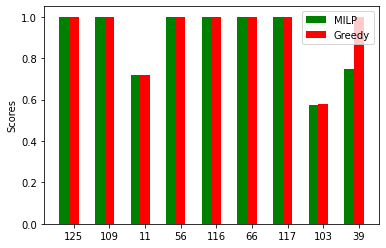

In [57]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

pvals = mean_scores['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
gpvals = greedy_mean_scores['Precision'].values.tolist()
rects3 = axp.bar(ind+width, gpvals, width, color='r')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8] ))
axp.legend( (rects1[0], rects3[0]), ('MILP', 'Greedy') )
plt.show()

#### Figure 3: Average recall

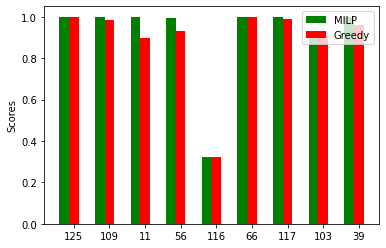

In [62]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axr = fig.add_subplot(111)

rvals = mean_scores['Recall'].values.tolist()
rects4 = axr.bar(ind, rvals, width, color='g')
grvals = greedy_mean_scores['Recall'].values.tolist()
rects6 = axr.bar(ind+width, grvals, width, color='r')

axr.set_ylabel('Scores')
axr.set_xticks(ind+width)
axr.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]))
axr.legend( (rects4[0], rects6[0]), ('MILP', 'Greedy') )

plt.show()

#### Figure 4: Average F1 score

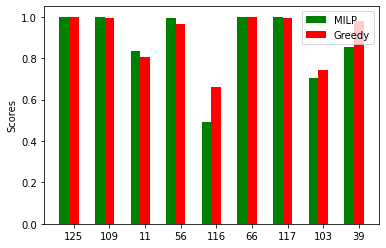

In [63]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axf = fig.add_subplot(111)


fvals = mean_scores['F1 score'].values.tolist()
rects7 = axf.bar(ind, fvals, width, color='g')
gfvals = greedy_mean_scores['F1 score'].values.tolist()
rects9 = axf.bar(ind+width, gfvals, width, color='r')

axf.set_ylabel('Scores')
axf.set_xticks(ind+width)
axf.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]))
axf.legend( (rects7[0], rects9[0]), ('MILP', 'Greedy') )

plt.show()